In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import time
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
%matplotlib inline

# raw = pd.read_csv("./used_car_train_20200313.csv", parse_dates=['regDate'])
train_data = pd.read_csv("./used_car_train_20200313.csv",sep=' ',parse_dates=['regDate'])
test_data = pd.read_csv("./used_car_testA_20200313.csv",sep=' ',parse_dates=['regDate'])
warnings.filterwarnings("ignore")

In [ ]:
# 一些个别的少数数据 测试集中  可以考虑手动调整

In [7]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


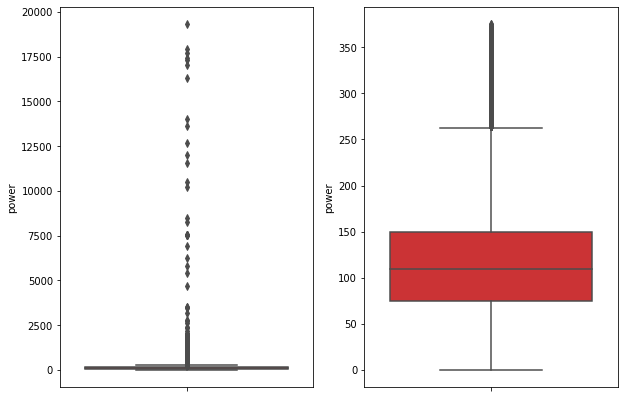

In [8]:
# 我们可以删掉一些异常数据，以 power 为例。  
# 这里删不删同学可以自行判断
# 但是要注意 test 的数据不能删 = = 不能掩耳盗铃是不是

# train_data = outliers_proc(train_data, 'power', scale=3)

In [11]:
# 训练集和测试集放在一起，方便构造特征
train_data['train']=1
test_data['train']=0
data = pd.concat([train_data, test_data], ignore_index=True)

In [17]:
data

,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,...,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time,city
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,...,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,4385.0,1
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,...,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,4757.0,4
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,...,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,4382.0,2
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,...,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,7125.0,
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,...,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,1531.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199032,199995,4.0,4,20160320,0.0,0.0,15.0,4.0,20903,0.0,...,-0.918571,0.774826,-2.021739,0.284664,0.130044,0.049833,0.028807,0.004616,7261.0,3
199033,199996,0.0,0,20160329,0.0,0.0,15.0,0.0,708,0.0,...,-0.841710,1.328253,-1.292675,0.268101,0.108095,0.066039,0.025468,0.025971,6014.0,1
199034,199997,0.0,1,20160305,1.0,1.0,15.0,49.0,6693,0.0,...,0.388595,-0.704689,-1.480710,0.269432,0.105724,0.117652,0.057479,0.015669,4345.0,3
199035,199998,0.0,1,20160404,0.0,1.0,15.0,27.0,96900,0.0,...,0.243566,-1.277411,-0.404881,0.261152,0.000490,0.137366,0.086216,0.051383,NaN,1


In [18]:
# data.isnull().sum()
# [fuelType,gearbox,bodyType]缺失值的处

In [19]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多，= =
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [20]:
# 删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

### 构造新的特征

In [12]:
# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [15]:
# 从邮编中提取城市信息，相当于加入了先验知识
# 小小的眼睛有着大大的迷惑
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [23]:
# 统计量特征 
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
Train_gb = train_data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

# 也算正确理解了 对某一类的统计量的具体做法

In [ ]:
# 长尾分布截断（把大于某部分的值归为一个值 例如 大于400的值 归为400）  l
# 一般是取log之后再进行归一化

### 特征选择

In [ ]:
# mlxtend的学习

# k_feature 太大会很难跑，没服务器，所以提前 interrupt 了
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
x = data.drop(['price'], axis=1)
x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
sfs.k_feature_names_ 